In [1]:
from PIL import Image, ImageDraw
import random
import os
import pandas as pd
import numpy as np

random.seed(42)  # Para reproducibilidad

def normalize_image(image):
    """Convierte una imagen PIL a array float32 normalizado [0, 1]."""
    return np.array(image, dtype=np.float32) / 255.0

def add_anomaly(image, square_size=32):
    """Dibuja de 1 a 3 círculos negros aleatorios en un parche dado."""
    draw = ImageDraw.Draw(image)
    num_circles = random.randint(1, 3)
    for _ in range(num_circles):
        r = random.randint(1, square_size // 2)
        cx = random.randint(r, square_size - r)
        cy = random.randint(r, square_size - r)
        draw.ellipse([(cx - r, cy - r), (cx + r, cy + r)], fill=(0, 0, 0) if image.mode == "RGB" else 0)
    return image

def patch_image_with_anomalies(input_image_path, anomaly_percentage=0.1, square_size=32, dataset_path="patched_dataset"):
    """
    Divide una imagen PNG en parches y añade anomalías a un porcentaje de ellos, guardando las imágenes y etiquetas.

    :param input_image_path: Ruta de la imagen original.
    :param anomaly_percentage: Porcentaje de parches con anomalías.
    :param square_size: Tamaño del parche (en píxeles).
    :param dataset_path: Carpeta donde se guardarán los parches y el CSV.
    """
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)

    image = Image.open(input_image_path)
    width, height = image.size
    dataset = []

    for x in range(0, width, square_size):
        for y in range(0, height, square_size):
            label = 0
            square_img = image.crop((x, y, x + square_size, y + square_size))
            if random.random() < anomaly_percentage:
                square_img = add_anomaly(square_img, square_size)
                label = 1

            square_filename = f"square_{x}_{y}.jpg"
            square_path = os.path.join(dataset_path, square_filename)
            square_img.save(square_path, "JPEG")
            dataset.append((square_filename, label))

    df = pd.DataFrame(dataset, columns=["filename", "label"])
    df.to_csv(os.path.join(dataset_path, "dataset_labels.csv"), index=False)
    print(f"Dataset generado: {len(dataset)} parches. Anomalías: {df['label'].sum()}")

img= patch_image_with_anomalies("pexels-pixmike-413195.jpg", anomaly_percentage=0.01)


Dataset generado: 7854 parches. Anomalías: 66


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Cargar el dataset desde el archivo CSV
dataset_path = "patched_dataset/dataset_labels.csv"
df = pd.read_csv(dataset_path)

# Mostrar las primeras filas del dataset
print(df.head(52))
random.seed(42)  # Para reproducibilidad

# Dividir el dataset en conjuntos de entrenamiento y prueba
X = df["filename"]
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Mostrar las primeras filas del conjunto de entrenamiento
print("Conjunto de entrenamiento:")
print(X_train.head(10))
print("Conjunto de prueba:")
print(X_test.head(10))

print(f"Total de imagenes en el conjunto de entrenamiento: {len(X_train)}")
print(f"Total de imagenes en el conjunto de prueba: {len(X_test)}")

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
# Mostrar las primeras filas del conjunto de entrenamiento
print("Conjunto de entrenamiento:")
print(X_train.head(10))
print("Conjunto de validación:")
print(X_val.head(10))

print(f"Total de imagenes en el conjunto de entrenamiento: {len(X_train)}")
print(f"Total de imagenes en el conjunto de validación: {len(X_val)}")

# Calcular cantidades y porcentajes
normal_count = df[df["label"] == 0].shape[0]
anomalous_count = df[df["label"] == 1].shape[0]
total_count = len(df)

normal_percentage = (normal_count / total_count) * 100
anomalous_percentage = (anomalous_count / total_count) * 100

# Obtener los índices de las imágenes anómalas (donde label == "anomalous")
anomalous_data = df[df["label"] == 1][["filename"]]
anomalous_filenames = anomalous_data["filename"].tolist()

# Mostrar los índices de las imágenes anómalas
print(anomalous_filenames)

# Mostrar resultados
print(f"Total de imágenes: {total_count}")
print(f"Porcentaje de normales: {normal_percentage:.2f}%")
print(f"Porcentaje de anómalos: {anomalous_percentage:.2f}%")

             filename  label
0      square_0_0.jpg      0
1     square_0_32.jpg      0
2     square_0_64.jpg      0
3     square_0_96.jpg      0
4    square_0_128.jpg      0
5    square_0_160.jpg      0
6    square_0_192.jpg      0
7    square_0_224.jpg      0
8    square_0_256.jpg      0
9    square_0_288.jpg      0
10   square_0_320.jpg      0
11   square_0_352.jpg      0
12   square_0_384.jpg      0
13   square_0_416.jpg      0
14   square_0_448.jpg      0
15   square_0_480.jpg      0
16   square_0_512.jpg      0
17   square_0_544.jpg      0
18   square_0_576.jpg      0
19   square_0_608.jpg      1
20   square_0_640.jpg      0
21   square_0_672.jpg      0
22   square_0_704.jpg      0
23   square_0_736.jpg      0
24   square_0_768.jpg      0
25   square_0_800.jpg      0
26   square_0_832.jpg      0
27   square_0_864.jpg      0
28   square_0_896.jpg      0
29   square_0_928.jpg      0
30   square_0_960.jpg      0
31   square_0_992.jpg      0
32  square_0_1024.jpg      0
33  square_0_1

## Flatten

In [3]:
def flatten_image(image_path):
    if os.path.exists(image_path):
        img = Image.open(image_path)
        img_array = np.array(img)
        flattened_image = img_array.flatten()
        return flattened_image
    else:
        print(f"El archivo {image_path} no se encuentra.")
        return None

In [4]:
import torch

flattened_images = []
labels = []

for _, row in df.iterrows():
    image_path = row['filename']
    flattened_image = flatten_image(f"patched_dataset/{image_path}")  # debe devolver un tensor
    flattened_tensor = torch.from_numpy(flattened_image)
    flattened_images.append(flattened_tensor)
    labels.append(row['label'])

# Convertimos la lista de tensores a un solo tensor
image_tensor = torch.stack(flattened_images)  # shape: [N, ...]


print(image_tensor.shape)  # Verificar la forma del tensor de imágenes

label_tensor = torch.tensor(labels)

print(image_tensor.shape)  # Verificar la forma del tensor

# Guardar como CSV
df_embeddings = pd.DataFrame(image_tensor.numpy())
df_embeddings['label'] = label_tensor.numpy()  # Añadir columna de etiquetas al final

df_embeddings.to_csv("tus_embeddings.csv", index=False)
print(" Embeddings guardados en 'tus_embeddings.csv'")

torch.Size([7854, 3072])
torch.Size([7854, 3072])
 Embeddings guardados en 'tus_embeddings.csv'


## Modelo preentrenado

In [5]:
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image


# Cargar modelo preentrenado ResNet-50
model = models.resnet50(pretrained=True)

# Eliminar la capa de clasificación (fc)
model = torch.nn.Sequential(*list(model.children())[:-1])

# Ver la arquitectura resultante
print(model)

model.eval()  # Poner en modo evaluación

# Transformaciones necesarias para ResNet-50
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # se usan estos valores por que son los que se usaron
                                                                                 # el entrenamiento de la resnet
])

# Lista para almacenar los embeddings
embeddings = []

# Iterar sobre las imágenes del dataset
for index, row in df.iterrows():
    image_path = row['filename']
    image = Image.open(f"patched_dataset/{image_path}")
    image = transform(image)
    image = image.unsqueeze(0)   #añadir una dimension mas para el batch

    with torch.no_grad():      #deshabilita el calculo del gradiente
        embedding = model(image)
    embedding = embedding.squeeze().cpu().numpy()   #squeeze: elimina dimensiones de tamaño 1 del tensor
                                                    #cpu: mueve el tensor embedding a la gpu
                                                    #numpy: convierte a un array de numpy
    embeddings.append(embedding)

#Crear un DataFrame con los embeddings
embeddings_df = pd.DataFrame(embeddings)
embeddings_df['label'] = df['label']  # Agregar las etiquetas al nuevo dataset

# Guardar el DataFrame con los embeddings
embeddings_df.to_csv("embeddings.csv", index=False)



/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


## Autoencoder

In [6]:
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import pandas as pd
import numpy as np
import ast
from tqdm import tqdm
from PIL import Image


import torch
import torch.nn as nn

# Definir el Autoencoder con espacio latente 16x1x1
class Autoencoder(nn.Module):
    def __init__(self, output_channels=3):
        super(Autoencoder, self).__init__()

        # Encoder (Reducir hasta 16x1x1)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=7, stride=7)
        )        # Decoder (Expandir desde 16x1x1 hasta 1x28x28)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 16, kernel_size=7, stride=7),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(16, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(32, output_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()  # Normalizar salida [0,1]
        )

    def forward(self, x):
        encoded = self.encoder(x)

        decoded = self.decoder(encoded)
        return decoded

# Prueba con un tensor de entrada (batch_size=1, canal=1, 28x28)
x_test = torch.randn(1, 3, 28, 28)

# Inicializar modelo y obtener salida
model = Autoencoder()
output = model(x_test)
print(model.state_dict)
# Imprimir dimensiones de salida
print("Dimensión final de salida:", output.shape)  # Esperado: (1, 1, 28, 28)


<bound method Module.state_dict of Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(16, 16, kernel_size=(7, 7), stride=(7, 7))
    (1): ReLU()
    (2): ConvTranspose2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): ReLU()
    (6): ConvTranspose2d(32, 3, kernel_size=

In [7]:
# Transformaciones
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28,28,)),
])



# Cargar y transformar todas las imágenes normales
image_tensors = []
for path in X_train.tolist():
    img = Image.open(f"patched_dataset/{str(path)}")
    img = transform(img)
    image_tensors.append(img)

X_train_encoder = torch.stack(image_tensors)

# Cargar y transformar todas las imágenes normales
image_tensors = []
for path in X_val.tolist():
    img = Image.open(f"patched_dataset/{str(path)}")
    img = transform(img)
    image_tensors.append(img)

X_val_encoder = torch.stack(image_tensors)

# Cargar y transformar todas las imágenes normales
image_tensors = []
for path in X_test:
    img = Image.open(f"patched_dataset/{str(path)}")
    img = transform(img)
    image_tensors.append(img)
X_test_encoder = torch.stack(image_tensors)

Entrenando Autoencoder con validación y early stopping...


Época 1/100: 100%|██████████| 40/40 [00:01<00:00, 33.96it/s]


Época [1/100], Pérdida entrenamiento: 0.067290, Pérdida validación: 0.050479


Época 2/100: 100%|██████████| 40/40 [00:00<00:00, 195.89it/s]


Época [2/100], Pérdida entrenamiento: 0.047315, Pérdida validación: 0.048115


Época 3/100: 100%|██████████| 40/40 [00:00<00:00, 200.26it/s]


Época [3/100], Pérdida entrenamiento: 0.045915, Pérdida validación: 0.046748


Época 4/100: 100%|██████████| 40/40 [00:00<00:00, 200.47it/s]


Época [4/100], Pérdida entrenamiento: 0.044342, Pérdida validación: 0.044366


Época 5/100: 100%|██████████| 40/40 [00:00<00:00, 199.49it/s]


Época [5/100], Pérdida entrenamiento: 0.039815, Pérdida validación: 0.038004


Época 6/100: 100%|██████████| 40/40 [00:00<00:00, 199.77it/s]


Época [6/100], Pérdida entrenamiento: 0.033495, Pérdida validación: 0.031855


Época 7/100: 100%|██████████| 40/40 [00:00<00:00, 199.28it/s]


Época [7/100], Pérdida entrenamiento: 0.029395, Pérdida validación: 0.029382


Época 8/100: 100%|██████████| 40/40 [00:00<00:00, 201.24it/s]


Época [8/100], Pérdida entrenamiento: 0.027835, Pérdida validación: 0.027897


Época 9/100: 100%|██████████| 40/40 [00:00<00:00, 197.66it/s]


Época [9/100], Pérdida entrenamiento: 0.026252, Pérdida validación: 0.026049


Época 10/100: 100%|██████████| 40/40 [00:00<00:00, 194.31it/s]


Época [10/100], Pérdida entrenamiento: 0.024704, Pérdida validación: 0.024781


Época 11/100: 100%|██████████| 40/40 [00:00<00:00, 196.04it/s]


Época [11/100], Pérdida entrenamiento: 0.023427, Pérdida validación: 0.023480


Época 12/100: 100%|██████████| 40/40 [00:00<00:00, 196.68it/s]


Época [12/100], Pérdida entrenamiento: 0.022537, Pérdida validación: 0.022693


Época 13/100: 100%|██████████| 40/40 [00:00<00:00, 196.69it/s]


Época [13/100], Pérdida entrenamiento: 0.021933, Pérdida validación: 0.021924


Época 14/100: 100%|██████████| 40/40 [00:00<00:00, 191.72it/s]


Época [14/100], Pérdida entrenamiento: 0.021377, Pérdida validación: 0.021568


Época 15/100: 100%|██████████| 40/40 [00:00<00:00, 196.09it/s]


Época [15/100], Pérdida entrenamiento: 0.021038, Pérdida validación: 0.021224


Época 16/100: 100%|██████████| 40/40 [00:00<00:00, 197.78it/s]


Época [16/100], Pérdida entrenamiento: 0.020703, Pérdida validación: 0.020970


Época 17/100: 100%|██████████| 40/40 [00:00<00:00, 197.39it/s]


Época [17/100], Pérdida entrenamiento: 0.020460, Pérdida validación: 0.020494


Época 18/100: 100%|██████████| 40/40 [00:00<00:00, 197.88it/s]


Época [18/100], Pérdida entrenamiento: 0.020139, Pérdida validación: 0.020445


Época 19/100: 100%|██████████| 40/40 [00:00<00:00, 198.49it/s]


Época [19/100], Pérdida entrenamiento: 0.019918, Pérdida validación: 0.020268


Época 20/100: 100%|██████████| 40/40 [00:00<00:00, 196.10it/s]


Época [20/100], Pérdida entrenamiento: 0.019711, Pérdida validación: 0.019899


Época 21/100: 100%|██████████| 40/40 [00:00<00:00, 200.22it/s]


Época [21/100], Pérdida entrenamiento: 0.019392, Pérdida validación: 0.019567


Época 22/100: 100%|██████████| 40/40 [00:00<00:00, 200.69it/s]


Época [22/100], Pérdida entrenamiento: 0.019174, Pérdida validación: 0.019454


Época 23/100: 100%|██████████| 40/40 [00:00<00:00, 200.19it/s]


Época [23/100], Pérdida entrenamiento: 0.018964, Pérdida validación: 0.019356


Época 24/100: 100%|██████████| 40/40 [00:00<00:00, 196.41it/s]


Época [24/100], Pérdida entrenamiento: 0.018802, Pérdida validación: 0.019000


Época 25/100: 100%|██████████| 40/40 [00:00<00:00, 196.68it/s]


Época [25/100], Pérdida entrenamiento: 0.018582, Pérdida validación: 0.018885


Época 26/100: 100%|██████████| 40/40 [00:00<00:00, 201.08it/s]


Época [26/100], Pérdida entrenamiento: 0.018336, Pérdida validación: 0.018715


Época 27/100: 100%|██████████| 40/40 [00:00<00:00, 200.79it/s]


Época [27/100], Pérdida entrenamiento: 0.018222, Pérdida validación: 0.018538


Época 28/100: 100%|██████████| 40/40 [00:00<00:00, 198.07it/s]


Época [28/100], Pérdida entrenamiento: 0.017986, Pérdida validación: 0.018212


Época 29/100: 100%|██████████| 40/40 [00:00<00:00, 193.86it/s]


Época [29/100], Pérdida entrenamiento: 0.017808, Pérdida validación: 0.018307


Época 30/100: 100%|██████████| 40/40 [00:00<00:00, 197.41it/s]


Época [30/100], Pérdida entrenamiento: 0.017764, Pérdida validación: 0.018003


Época 31/100: 100%|██████████| 40/40 [00:00<00:00, 197.20it/s]


Época [31/100], Pérdida entrenamiento: 0.017641, Pérdida validación: 0.017832


Época 32/100: 100%|██████████| 40/40 [00:00<00:00, 198.04it/s]


Época [32/100], Pérdida entrenamiento: 0.017458, Pérdida validación: 0.017734


Época 33/100: 100%|██████████| 40/40 [00:00<00:00, 195.57it/s]


Época [33/100], Pérdida entrenamiento: 0.017282, Pérdida validación: 0.017559


Época 34/100: 100%|██████████| 40/40 [00:00<00:00, 197.08it/s]


Época [34/100], Pérdida entrenamiento: 0.017083, Pérdida validación: 0.017359


Época 35/100: 100%|██████████| 40/40 [00:00<00:00, 200.78it/s]


Época [35/100], Pérdida entrenamiento: 0.016920, Pérdida validación: 0.017137


Época 36/100: 100%|██████████| 40/40 [00:00<00:00, 197.65it/s]


Época [36/100], Pérdida entrenamiento: 0.016747, Pérdida validación: 0.016945


Época 37/100: 100%|██████████| 40/40 [00:00<00:00, 200.16it/s]


Época [37/100], Pérdida entrenamiento: 0.016554, Pérdida validación: 0.016931


Época 38/100: 100%|██████████| 40/40 [00:00<00:00, 194.06it/s]


Época [38/100], Pérdida entrenamiento: 0.016487, Pérdida validación: 0.016789


Época 39/100: 100%|██████████| 40/40 [00:00<00:00, 200.26it/s]


Época [39/100], Pérdida entrenamiento: 0.016300, Pérdida validación: 0.016674


Época 40/100: 100%|██████████| 40/40 [00:00<00:00, 197.72it/s]


Época [40/100], Pérdida entrenamiento: 0.016199, Pérdida validación: 0.016535


Época 41/100: 100%|██████████| 40/40 [00:00<00:00, 199.88it/s]


Época [41/100], Pérdida entrenamiento: 0.016109, Pérdida validación: 0.016374


Época 42/100: 100%|██████████| 40/40 [00:00<00:00, 196.16it/s]


Época [42/100], Pérdida entrenamiento: 0.015987, Pérdida validación: 0.016301


Época 43/100: 100%|██████████| 40/40 [00:00<00:00, 200.46it/s]


Época [43/100], Pérdida entrenamiento: 0.015957, Pérdida validación: 0.016244


Época 44/100: 100%|██████████| 40/40 [00:00<00:00, 197.51it/s]


Época [44/100], Pérdida entrenamiento: 0.015898, Pérdida validación: 0.016129


Época 45/100: 100%|██████████| 40/40 [00:00<00:00, 195.54it/s]


Época [45/100], Pérdida entrenamiento: 0.015814, Pérdida validación: 0.015965


Época 46/100: 100%|██████████| 40/40 [00:00<00:00, 195.05it/s]


Época [46/100], Pérdida entrenamiento: 0.015766, Pérdida validación: 0.016021


Época 47/100: 100%|██████████| 40/40 [00:00<00:00, 199.15it/s]


Época [47/100], Pérdida entrenamiento: 0.015620, Pérdida validación: 0.015927


Época 48/100: 100%|██████████| 40/40 [00:00<00:00, 196.78it/s]


Época [48/100], Pérdida entrenamiento: 0.015624, Pérdida validación: 0.016048


Época 49/100: 100%|██████████| 40/40 [00:00<00:00, 197.13it/s]


Época [49/100], Pérdida entrenamiento: 0.015571, Pérdida validación: 0.016092


Época 50/100: 100%|██████████| 40/40 [00:00<00:00, 197.14it/s]


Época [50/100], Pérdida entrenamiento: 0.015550, Pérdida validación: 0.015896


Época 51/100: 100%|██████████| 40/40 [00:00<00:00, 199.99it/s]


Época [51/100], Pérdida entrenamiento: 0.015500, Pérdida validación: 0.015909


Época 52/100: 100%|██████████| 40/40 [00:00<00:00, 198.62it/s]


Época [52/100], Pérdida entrenamiento: 0.015387, Pérdida validación: 0.015648


Época 53/100: 100%|██████████| 40/40 [00:00<00:00, 195.83it/s]


Época [53/100], Pérdida entrenamiento: 0.015328, Pérdida validación: 0.015621


Época 54/100: 100%|██████████| 40/40 [00:00<00:00, 190.01it/s]


Época [54/100], Pérdida entrenamiento: 0.015250, Pérdida validación: 0.015656


Época 55/100: 100%|██████████| 40/40 [00:00<00:00, 196.63it/s]


Época [55/100], Pérdida entrenamiento: 0.015262, Pérdida validación: 0.015752


Época 56/100: 100%|██████████| 40/40 [00:00<00:00, 199.92it/s]


Época [56/100], Pérdida entrenamiento: 0.015327, Pérdida validación: 0.015767


Época 57/100: 100%|██████████| 40/40 [00:00<00:00, 198.07it/s]


Época [57/100], Pérdida entrenamiento: 0.015265, Pérdida validación: 0.015584


Época 58/100: 100%|██████████| 40/40 [00:00<00:00, 197.06it/s]


Época [58/100], Pérdida entrenamiento: 0.015179, Pérdida validación: 0.015450


Época 59/100: 100%|██████████| 40/40 [00:00<00:00, 199.13it/s]


Época [59/100], Pérdida entrenamiento: 0.015172, Pérdida validación: 0.015526


Época 60/100: 100%|██████████| 40/40 [00:00<00:00, 196.90it/s]


Época [60/100], Pérdida entrenamiento: 0.015118, Pérdida validación: 0.015516


Época 61/100: 100%|██████████| 40/40 [00:00<00:00, 197.76it/s]


Época [61/100], Pérdida entrenamiento: 0.015060, Pérdida validación: 0.015504


Época 62/100: 100%|██████████| 40/40 [00:00<00:00, 197.22it/s]


Época [62/100], Pérdida entrenamiento: 0.015056, Pérdida validación: 0.015405


Época 63/100: 100%|██████████| 40/40 [00:00<00:00, 200.15it/s]


Época [63/100], Pérdida entrenamiento: 0.015051, Pérdida validación: 0.015441


Época 64/100: 100%|██████████| 40/40 [00:00<00:00, 199.89it/s]


Época [64/100], Pérdida entrenamiento: 0.014987, Pérdida validación: 0.015434


Época 65/100: 100%|██████████| 40/40 [00:00<00:00, 199.37it/s]


Época [65/100], Pérdida entrenamiento: 0.015037, Pérdida validación: 0.015381


Época 66/100: 100%|██████████| 40/40 [00:00<00:00, 199.72it/s]


Época [66/100], Pérdida entrenamiento: 0.014977, Pérdida validación: 0.015375


Época 67/100: 100%|██████████| 40/40 [00:00<00:00, 197.95it/s]


Época [67/100], Pérdida entrenamiento: 0.014927, Pérdida validación: 0.015288


Época 68/100: 100%|██████████| 40/40 [00:00<00:00, 200.73it/s]


Época [68/100], Pérdida entrenamiento: 0.014897, Pérdida validación: 0.015487


Época 69/100: 100%|██████████| 40/40 [00:00<00:00, 197.60it/s]


Época [69/100], Pérdida entrenamiento: 0.014901, Pérdida validación: 0.015201


Época 70/100: 100%|██████████| 40/40 [00:00<00:00, 198.47it/s]


Época [70/100], Pérdida entrenamiento: 0.014851, Pérdida validación: 0.015163


Época 71/100: 100%|██████████| 40/40 [00:00<00:00, 200.09it/s]


Época [71/100], Pérdida entrenamiento: 0.014815, Pérdida validación: 0.015157


Época 72/100: 100%|██████████| 40/40 [00:00<00:00, 199.92it/s]


Época [72/100], Pérdida entrenamiento: 0.014857, Pérdida validación: 0.015162


Época 73/100: 100%|██████████| 40/40 [00:00<00:00, 198.44it/s]


Época [73/100], Pérdida entrenamiento: 0.014782, Pérdida validación: 0.015399


Época 74/100: 100%|██████████| 40/40 [00:00<00:00, 199.62it/s]


Época [74/100], Pérdida entrenamiento: 0.014768, Pérdida validación: 0.015071


Época 75/100: 100%|██████████| 40/40 [00:00<00:00, 197.66it/s]


Época [75/100], Pérdida entrenamiento: 0.014781, Pérdida validación: 0.015133


Época 76/100: 100%|██████████| 40/40 [00:00<00:00, 191.68it/s]


Época [76/100], Pérdida entrenamiento: 0.014744, Pérdida validación: 0.015032


Época 77/100: 100%|██████████| 40/40 [00:00<00:00, 199.16it/s]


Época [77/100], Pérdida entrenamiento: 0.014663, Pérdida validación: 0.015204


Época 78/100: 100%|██████████| 40/40 [00:00<00:00, 197.80it/s]


Época [78/100], Pérdida entrenamiento: 0.014742, Pérdida validación: 0.015017


Época 79/100: 100%|██████████| 40/40 [00:00<00:00, 197.94it/s]


Época [79/100], Pérdida entrenamiento: 0.014647, Pérdida validación: 0.015051


Época 80/100: 100%|██████████| 40/40 [00:00<00:00, 197.45it/s]


Época [80/100], Pérdida entrenamiento: 0.014677, Pérdida validación: 0.015143


Época 81/100: 100%|██████████| 40/40 [00:00<00:00, 198.33it/s]


Época [81/100], Pérdida entrenamiento: 0.014681, Pérdida validación: 0.015128


Época 82/100: 100%|██████████| 40/40 [00:00<00:00, 197.54it/s]


Época [82/100], Pérdida entrenamiento: 0.014552, Pérdida validación: 0.015144


Época 83/100: 100%|██████████| 40/40 [00:00<00:00, 195.29it/s]


Época [83/100], Pérdida entrenamiento: 0.014645, Pérdida validación: 0.015198


Época 84/100: 100%|██████████| 40/40 [00:00<00:00, 192.38it/s]


Época [84/100], Pérdida entrenamiento: 0.014647, Pérdida validación: 0.015070


Época 85/100: 100%|██████████| 40/40 [00:00<00:00, 199.22it/s]


Época [85/100], Pérdida entrenamiento: 0.014604, Pérdida validación: 0.015015


Época 86/100: 100%|██████████| 40/40 [00:00<00:00, 199.85it/s]


Época [86/100], Pérdida entrenamiento: 0.014554, Pérdida validación: 0.015074


Época 87/100: 100%|██████████| 40/40 [00:00<00:00, 197.28it/s]


Época [87/100], Pérdida entrenamiento: 0.014560, Pérdida validación: 0.015049


Época 88/100: 100%|██████████| 40/40 [00:00<00:00, 196.59it/s]


Época [88/100], Pérdida entrenamiento: 0.014547, Pérdida validación: 0.014880


Época 89/100: 100%|██████████| 40/40 [00:00<00:00, 196.93it/s]


Época [89/100], Pérdida entrenamiento: 0.014551, Pérdida validación: 0.014955


Época 90/100: 100%|██████████| 40/40 [00:00<00:00, 197.15it/s]


Época [90/100], Pérdida entrenamiento: 0.014486, Pérdida validación: 0.014962


Época 91/100: 100%|██████████| 40/40 [00:00<00:00, 196.60it/s]


Época [91/100], Pérdida entrenamiento: 0.014429, Pérdida validación: 0.014789


Época 92/100: 100%|██████████| 40/40 [00:00<00:00, 196.63it/s]


Época [92/100], Pérdida entrenamiento: 0.014402, Pérdida validación: 0.014932


Época 93/100: 100%|██████████| 40/40 [00:00<00:00, 194.97it/s]


Época [93/100], Pérdida entrenamiento: 0.014422, Pérdida validación: 0.014821


Época 94/100: 100%|██████████| 40/40 [00:00<00:00, 199.28it/s]


Época [94/100], Pérdida entrenamiento: 0.014467, Pérdida validación: 0.014881


Época 95/100: 100%|██████████| 40/40 [00:00<00:00, 194.96it/s]


Época [95/100], Pérdida entrenamiento: 0.014438, Pérdida validación: 0.014781


Época 96/100: 100%|██████████| 40/40 [00:00<00:00, 197.05it/s]


Época [96/100], Pérdida entrenamiento: 0.014491, Pérdida validación: 0.014864


Época 97/100: 100%|██████████| 40/40 [00:00<00:00, 193.84it/s]


Época [97/100], Pérdida entrenamiento: 0.014359, Pérdida validación: 0.014795


Época 98/100: 100%|██████████| 40/40 [00:00<00:00, 194.77it/s]


Época [98/100], Pérdida entrenamiento: 0.014395, Pérdida validación: 0.014842


Época 99/100: 100%|██████████| 40/40 [00:00<00:00, 199.11it/s]


Época [99/100], Pérdida entrenamiento: 0.014380, Pérdida validación: 0.014704


Época 100/100: 100%|██████████| 40/40 [00:00<00:00, 194.77it/s]


Época [100/100], Pérdida entrenamiento: 0.014358, Pérdida validación: 0.014747


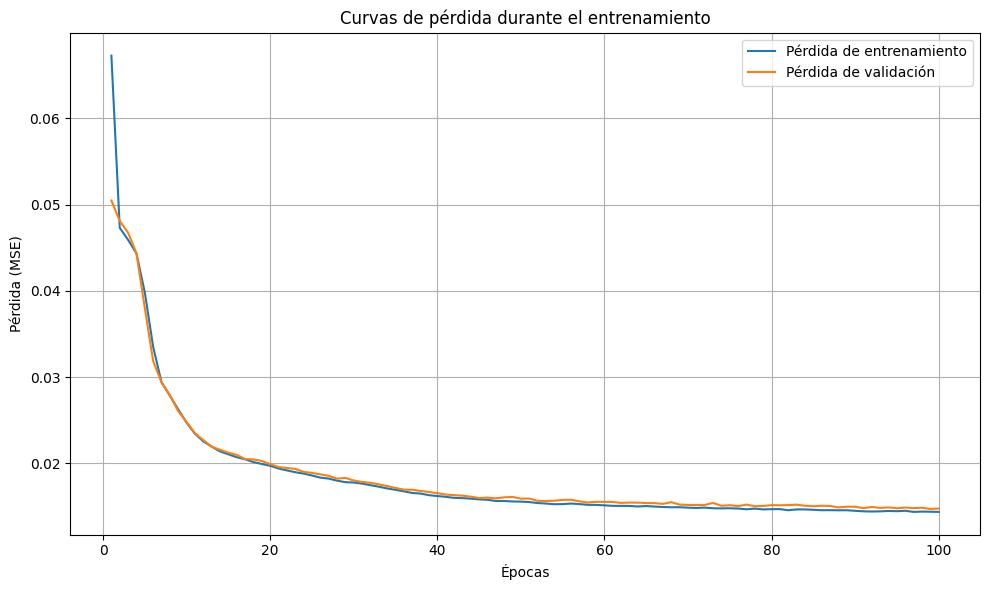

/var/tmp/ipykernel_16067/1146214147.py:96: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("autoencoder_best.pth"))



Entrenamiento final sobre todos los datos (3 épocas)...


Fine-tuning Época 1/3: 100%|██████████| 50/50 [00:00<00:00, 156.50it/s]


Fine-tuning época [1/3], Pérdida: 0.014394


Fine-tuning Época 2/3: 100%|██████████| 50/50 [00:00<00:00, 191.06it/s]


Fine-tuning época [2/3], Pérdida: 0.014449


Fine-tuning Época 3/3: 100%|██████████| 50/50 [00:00<00:00, 192.39it/s]

Fine-tuning época [3/3], Pérdida: 0.014285

Modelo final guardado en autoencoder_final.pth


In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparámetros
batch_size = 128
learning_rate = 0.001
num_epochs = 100
patience = 10  # Early stopping

# DataLoaders (asegúrate de que X_train_encoder y X_val_encoder están definidos)
train_loader = torch.utils.data.DataLoader(X_train_encoder, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val_encoder, batch_size=batch_size, shuffle=False)

# Modelo Autoencoder (definido previamente)
autoencoder = Autoencoder().to(device)

# Función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Variables de control
best_val_loss = float('inf')
epochs_without_improvement = 0

# Para la gráfica
train_losses = []
val_losses = []

# Entrenamiento
print("Entrenando Autoencoder con validación y early stopping...")
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for img in tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs}"):
        images = img.to(device)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validación
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img in val_loader:
            images = img.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Época [{epoch+1}/{num_epochs}], Pérdida entrenamiento: {train_loss:.6f}, Pérdida validación: {val_loss:.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(autoencoder.state_dict(), "autoencoder_best.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Deteniendo entrenamiento por early stopping (sin mejora en {patience} épocas).")
            break

# Gráfica de pérdidas
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Guardar el modelo mejor
torch.save(autoencoder.state_dict(), "autoencoder_best.pth")
# Cargar el modelo guardado
autoencoder.load_state_dict(torch.load("autoencoder_best.pth"))

# Crear nuevo DataLoader con TODO el conjunto de entrenamiento y validación
full_dataset = torch.utils.data.ConcatDataset([X_train_encoder, X_val_encoder])
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# Entrenamiento final con todo el conjunto (1-3 épocas recomendadas)
final_epochs = 3
print(f"\nEntrenamiento final sobre todos los datos ({final_epochs} épocas)...")
autoencoder.train()

for epoch in range(final_epochs):
    running_loss = 0.0
    for img in tqdm(full_loader, desc=f"Fine-tuning Época {epoch+1}/{final_epochs}"):
        images = img[0].to(device) if isinstance(img, (tuple, list)) else img.to(device)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Fine-tuning época [{epoch+1}/{final_epochs}], Pérdida: {running_loss / len(full_loader):.6f}")

# Guardar modelo final ajustado
final_model_path = "autoencoder_final.pth"
torch.save(autoencoder.state_dict(), final_model_path)
print(f"\nModelo final guardado en {final_model_path}")



In [9]:
# ==========================
# Cargar modelo y evaluar solo el Encoder
# ==========================

model = Autoencoder()
model.load_state_dict(torch.load(final_model_path))
model.eval()  # Modo evaluación

# Extraer solo el encoder
encoder = autoencoder.encoder
encoder.to(device)
encoder.eval()


# Lista para almacenar los embeddings
embeddings = []


# Iterar sobre las imágenes del dataset
for image in tqdm(torch.utils.data.ConcatDataset([X_train_encoder,X_val_encoder,X_test_encoder]), desc="Extrayendo embeddings"):
    image = image.unsqueeze(0).to(device)   #añadir una dimension mas para el batch

    with torch.no_grad():      #deshabilita el calculo del gradiente
        embedding = encoder(image)
    embedding = embedding.squeeze().cpu().numpy()   #squeeze: elimina dimensiones de tamaño 1 del tensor
                                                    #cpu: mueve el tensor embedding a la gpu
                                                    #numpy: convierte a un array de numpy
    embeddings.append(embedding)

# Procesar todas las imágenes en el dataset externo
print("Extrayendo embeddings...")


# Convertir a DataFrame y guardar
embeddings_df = pd.DataFrame(embeddings)
# Cada y_* es una lista o array de etiquetas
y_all = list(y_train) + list(y_val) + list(y_test)
embeddings_df['label'] = y_all 

# Guardar en archivo CSV
output_file = "dataset_embeddings_encoder.csv"
embeddings_df.to_csv(output_file, index=False)

print(f"Embeddings guardados en {output_file}")

/var/tmp/ipykernel_16067/921082416.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(final_model_path))
Extrayendo embeddings: 100%|██████

Extrayendo embeddings...
Embeddings guardados en dataset_embeddings_encoder.csv


## RESNET AUTOENCODER

In [10]:
import torch
import torch.nn as nn
import torchvision.models as models


class ViewLayer(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

        # Congelar los parámetros del encoder preentrenado
        for param in list(resnet.children())[:8]:
            for p in param.parameters():
                p.requires_grad = False

        # Compacto: todas las capas convolucionales hasta layer4
        self.encoder = nn.Sequential(*list(resnet.children())[:8],
                                     nn.MaxPool2d(kernel_size=4,stride=1),
                                     nn.Flatten(),
                                     nn.Linear(2048,1024),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(1024, 256),
                                     nn.ReLU(),
                                     nn.Dropout(0.2),
                                     nn.Linear(256, 64),
                                     nn.ReLU())


        # Decoder: invertir el proceso usando conv transpuestas
        self.decoder = nn.Sequential(
            # Primero, expandimos [B, 64] → [B, 256]
            nn.Linear(64, 256),
            nn.ReLU(),

            # Expandimos más: [B, 256] → [B, 2048]
            nn.Linear(256, 2048*4*4),
            nn.ReLU(),
            ViewLayer((2048, 4, 4)),  # Cambiar la forma a [B, 2048, 4, 4]
            # Ahora, aplicamos las capas


            nn.ConvTranspose2d(2048, 512, kernel_size=4, stride=2, padding=1),  # -> [B, 512, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),    # -> [B, 256, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),     # -> [B, 64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),      # -> [B, 64, 128, 128]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),       # -> [B, 3, 128, 128]
            nn.Sigmoid()  # para imágenes normalizadas en [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Prueba con un tensor de entrada (batch_size=1, canal=3, 28x28)
x_test = torch.randn(1, 3, 128, 128)

# Inicializar modelo y obtener salida
model = ResNetAutoencoder()
output = model(x_test)
print(model.state_dict)
output_encoder=model.encoder(x_test)

# Imprimir dimensiones de salida
print("Dimensión final de salida:", output.shape)  # Esperado: (1, 1, 28, 28)
print("Dimensión final de salida encoder:", output_encoder.shape)  # Esperado: (1, 1, 28, 28)

from torchinfo import summary
# Resumen del modelo
summary(model, input_size=(1, 3, 128, 128), device='cuda')


/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.state_dict of ResNetAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsa

Layer (type:depth-idx)                        Output Shape              Param #
ResNetAutoencoder                             [1, 3, 128, 128]          --
├─Sequential: 1-1                             [1, 64]                   --
│    └─Conv2d: 2-1                            [1, 64, 64, 64]           (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 64, 64]           (128)
│    └─ReLU: 2-3                              [1, 64, 64, 64]           --
│    └─MaxPool2d: 2-4                         [1, 64, 32, 32]           --
│    └─Sequential: 2-5                        [1, 256, 32, 32]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 32, 32]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 32, 32]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 32, 32]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 16, 16]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 16, 16]       

In [11]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((128, 128)),  # <--- convierte a RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])



# Cargar y transformar todas las imágenes normales
image_tensors = []
for path in X_train.tolist():
    img = Image.open(f"patched_dataset/{str(path)}")
    img = transform(img)
    image_tensors.append(img)

X_train_resnet = torch.stack(image_tensors)

# Cargar y transformar todas las imágenes normales
image_tensors = []
for path in X_val.tolist():
    img = Image.open(f"patched_dataset/{str(path)}")
    img = transform(img)
    image_tensors.append(img)

X_val_resnet = torch.stack(image_tensors)


# Cargar y transformar todas las imágenes normales
image_tensors = []
for path in X_test:
    img = Image.open(f"patched_dataset/{str(path)}")
    img = transform(img)
    image_tensors.append(img)

X_test_resnet = torch.stack(image_tensors)

Entrenando Autoencoder con validación y early stopping...


Época 1/100: 100%|██████████| 40/40 [00:12<00:00,  3.10it/s]


Época [1/100], Pérdida entrenamiento: 1.770008, Pérdida validación: 1.712637


Época 2/100: 100%|██████████| 40/40 [00:13<00:00,  3.03it/s]


Época [2/100], Pérdida entrenamiento: 1.744662, Pérdida validación: 1.725623


Época 3/100: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


Época [3/100], Pérdida entrenamiento: 1.745362, Pérdida validación: 1.715913


Época 4/100: 100%|██████████| 40/40 [00:13<00:00,  2.87it/s]


Época [4/100], Pérdida entrenamiento: 1.743931, Pérdida validación: 1.715831


Época 5/100: 100%|██████████| 40/40 [00:14<00:00,  2.86it/s]


Época [5/100], Pérdida entrenamiento: 1.739292, Pérdida validación: 1.715831


Época 6/100: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Época [6/100], Pérdida entrenamiento: 1.742088, Pérdida validación: 1.715831


Época 7/100: 100%|██████████| 40/40 [00:13<00:00,  2.95it/s]


Época [7/100], Pérdida entrenamiento: 1.740712, Pérdida validación: 1.715831


Época 8/100:  78%|███████▊  | 31/40 [00:10<00:03,  2.90it/s]

Época 8/100: 100%|██████████| 40/40 [00:13<00:00,  2.94it/s]


Época [8/100], Pérdida entrenamiento: 1.742458, Pérdida validación: 1.715831


Época 9/100: 100%|██████████| 40/40 [00:13<00:00,  2.92it/s]


Época [9/100], Pérdida entrenamiento: 1.741711, Pérdida validación: 1.715831


Época 10/100: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Época [10/100], Pérdida entrenamiento: 1.741105, Pérdida validación: 1.715831


Época 11/100: 100%|██████████| 40/40 [00:13<00:00,  2.91it/s]


Época [11/100], Pérdida entrenamiento: 1.741828, Pérdida validación: 1.715831
Deteniendo entrenamiento por early stopping (sin mejora en 10 épocas).


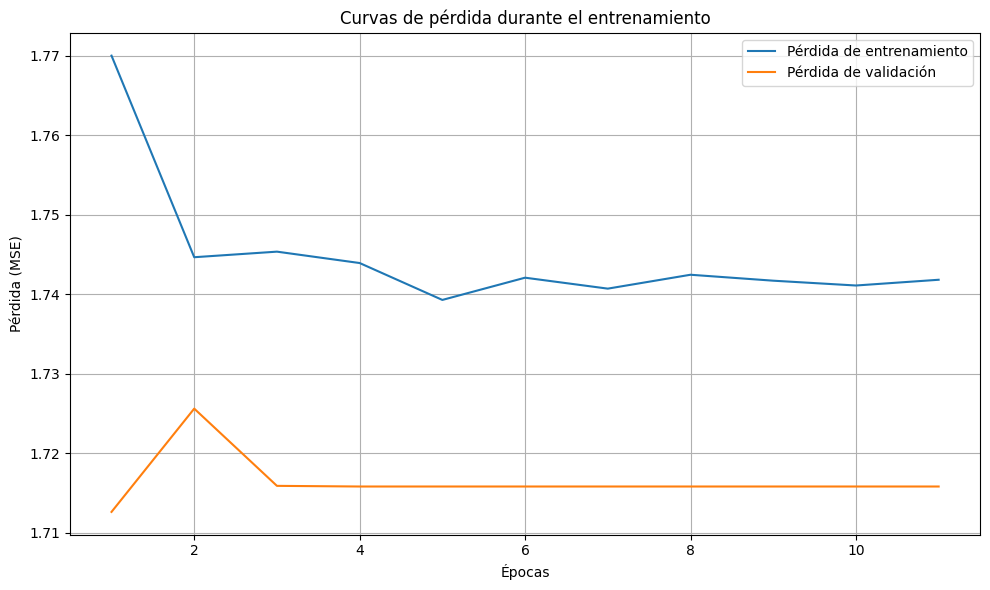

/var/tmp/ipykernel_16067/3375057493.py:97: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load("autoencoder_resnet_best.pth"))



Entrenamiento final sobre todos los datos (3 épocas)...


Fine-tuning Época 1/3: 100%|██████████| 50/50 [00:17<00:00,  2.92it/s]


Fine-tuning época [1/3], Pérdida: 1.734420


Fine-tuning Época 2/3: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Fine-tuning época [2/3], Pérdida: 1.732716


Fine-tuning Época 3/3: 100%|██████████| 50/50 [00:17<00:00,  2.91it/s]


Fine-tuning época [3/3], Pérdida: 1.731590

Modelo final guardado en autoencoder_resnet_codificacion_final.pth


In [12]:


# Configurar dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparámetros
batch_size = 128
learning_rate = 0.001
num_epochs = 10



# Hiperparámetros
batch_size = 128
learning_rate = 0.01
num_epochs = 100
patience = 10  # Early stopping

# DataLoaders (asegúrate de que X_train_encoder y X_val_encoder están definidos)
train_loader = torch.utils.data.DataLoader(X_train_resnet, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val_resnet, batch_size=batch_size, shuffle=False)

# Crear instancia del Autoencoder
autoencoder = ResNetAutoencoder().to(device)

# Definir función de pérdida y optimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

# Variables de control
best_val_loss = float('inf')
epochs_without_improvement = 0

# Para la gráfica
train_losses = []
val_losses = []

# Entrenamiento
print("Entrenando Autoencoder con validación y early stopping...")
for epoch in range(num_epochs):
    autoencoder.train()
    running_loss = 0.0

    for img in tqdm(train_loader, desc=f"Época {epoch+1}/{num_epochs}"):
        images = img.to(device)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validación
    autoencoder.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img in val_loader:
            images = img.to(device)
            outputs = autoencoder(images)
            loss = criterion(outputs, images)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    print(f"Época [{epoch+1}/{num_epochs}], Pérdida entrenamiento: {train_loss:.6f}, Pérdida validación: {val_loss:.6f}")

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(autoencoder.state_dict(), "autoencoder_best.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Deteniendo entrenamiento por early stopping (sin mejora en {patience} épocas).")
            break

# Gráfica de pérdidas
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Pérdida de entrenamiento')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida (MSE)')
plt.title('Curvas de pérdida durante el entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Guardar el modelo mejor
torch.save(autoencoder.state_dict(), "autoencoder_resnet_best.pth")
# Cargar el modelo guardado
autoencoder.load_state_dict(torch.load("autoencoder_resnet_best.pth"))

# Crear nuevo DataLoader con TODO el conjunto de entrenamiento y validación
full_dataset = torch.utils.data.ConcatDataset([X_train_resnet, X_val_resnet])
full_loader = torch.utils.data.DataLoader(full_dataset, batch_size=batch_size, shuffle=True)

# Entrenamiento final con todo el conjunto (1-3 épocas recomendadas)
final_epochs = 3
print(f"\nEntrenamiento final sobre todos los datos ({final_epochs} épocas)...")
autoencoder.train()

for epoch in range(final_epochs):
    running_loss = 0.0
    for img in tqdm(full_loader, desc=f"Fine-tuning Época {epoch+1}/{final_epochs}"):
        images = img[0].to(device) if isinstance(img, (tuple, list)) else img.to(device)
        outputs = autoencoder(images)
        loss = criterion(outputs, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Fine-tuning época [{epoch+1}/{final_epochs}], Pérdida: {running_loss / len(full_loader):.6f}")

# Guardar modelo final ajustado
final_model_path = "autoencoder_resnet_codificacion_final.pth"
torch.save(autoencoder.state_dict(), final_model_path)
print(f"\nModelo final guardado en {final_model_path}")




In [13]:
# ==========================
# Cargar modelo y evaluar solo el Encoder
# ==========================

# Cargar el modelo entrenado
model = ResNetAutoencoder()
model.load_state_dict(torch.load("autoencoder_resnet_codificacion_final.pth"))
model.eval()  # Modo evaluación

# Extraer solo el encoder
encoder = model.encoder
encoder.to(device)
encoder.eval()



# Lista para almacenar los embeddings
embeddings = []

for image in tqdm(torch.utils.data.ConcatDataset([X_train_resnet,X_val_resnet,X_test_resnet]), desc="Extrayendo embeddings"):
    image = image.unsqueeze(0).to(device)   #añadir una dimension mas para el batch

    with torch.no_grad():      #deshabilita el calculo del gradiente
        embedding = encoder(image)
    embedding = embedding.squeeze().cpu().numpy()   #squeeze: elimina dimensiones de tamaño 1 del tensor
                                                    #cpu: mueve el tensor embedding a la gpu
                                                    #numpy: convierte a un array de numpy
    embeddings.append(embedding)

# Procesar todas las imágenes en el dataset externo
print("Extrayendo embeddings...")


# Convertir a DataFrame y guardar
embeddings_df = pd.DataFrame(embeddings)
# Cada y_* es una lista o array de etiquetas
y_all = list(y_train) + list(y_val) + list(y_test)
embeddings_df['label'] = y_all 

# Guardar en archivo CSV
output_file = "dataset_embeddings_encoder_resnet.csv"
embeddings_df.to_csv(output_file, index=False)

print(f"Embeddings guardados en {output_file}")

/var/tmp/ipykernel_16067/2197323532.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("autoencoder_resnet_codificacion_final.pth"))
Extray

Extrayendo embeddings...
Embeddings guardados en dataset_embeddings_encoder_resnet.csv


## Distribución de los datos con centroide

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def AnomalyDetector(file_path, k=3):  # k controla qué tan lejos consideramos anómalo
    df = pd.read_csv(file_path)

    embedding_columns = df.columns[:-1]  # nombres de columnas excepto la última
    embeddings = df[embedding_columns].values

    # Calcular el centroide
    centroid = np.mean(embeddings, axis=0)
    distances = np.linalg.norm(embeddings - centroid, axis=1)

    # Calcular la media y desviación estándar de las distancias
    mean_dist = np.mean(distances)
    std_dist = np.std(distances)

    # Definir umbral basado en k desviaciones estándar
    threshold = mean_dist + k * std_dist

    # Crear vector de etiquetas: 1 = anómalo, 0 = normal
    predicted_labels = (distances > threshold).astype(int)

    return predicted_labels,distances


In [63]:
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score

# ==========================
# Cargar los Embeddings
# ==========================
file_path = "dataset_embeddings_encoder_resnet.csv"  # Cambia con la ruta correcta


print("Anomaly Detector")
predicted_labels,distances = AnomalyDetector(file_path,0.2)
print(distances)


acc= accuracy_score(y, predicted_labels)
f1 = f1_score(y, predicted_labels)
auc= roc_auc_score(y,distances)
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Area bajo al curva ROC",auc)

Anomaly Detector
[4192.09492846  789.1662679   398.91533493 ... 2244.9390984  1375.5516553
  541.45274708]
Accuracy: 0.6478227654698243
F1 Score: 0.01775568181818182
Area bajo al curva ROC 0.4714673701576629


## Método Antonio

In [32]:
import torch

class GDAOneClassTorch:
    def fit(self, X, threshold_param=1.0):
        """
        Ajusta el modelo GDA para una sola clase usando PyTorch.
        :param X: Tensor de forma (n_samples, n_features)
        """
        self.mu = X.mean(dim=0)
        self.centered = X - self.mu
        self.sigma = torch.matmul(self.centered.T, self.centered) / X.shape[0]     #calcula la matriz de covarianzas

        # Regularización para evitar matriz singular
        epsilon = 1e-5
        self.sigma += epsilon * torch.eye(self.sigma.shape[0])
        self.inv_sigma = torch.inverse(self.sigma)
        self.det_sigma = torch.det(self.sigma)

        scores= self.score(X)


        mean_score = scores.mean()
        std_score = scores.std()
        self.threshold = mean_score - threshold_param * std_score

    def score(self, X):
        scores=[]
        for i in range(len(X)):
            centered = X[i] - self.mu
            tmp = torch.matmul(centered, self.inv_sigma)
            quad_form = (tmp * centered).sum()
            scores.append(-0.5 * quad_form)
        return torch.tensor(scores)

    def predict(self, X):
        scores = self.score(X)
        preds=[] 
        for i in range(len(scores)):
            pred= 1 if scores[i]< self.threshold else 0
            preds.append((i, pred))

        return preds



    def print_parameters(self):
        """
        Imprime el vector de medias y la matriz de covarianza.
        """
        print("Vector de medias (mu):")
        print(self.mu)
        print("\nMatriz de covarianza (sigma):")
        print(self.sigma)

    def print_score(self, X):
      """
      Imprime y retorna la densidad de cada punto en X.
      :param X: Tensor (n_samples, n_features)
      :return: Diccionario {índice: densidad}
      """
      probs = self.score(X)
      scores = dict()

      for i, p in enumerate(probs):
          valor = p.item()
          print(f"Densidad del punto {i}: {valor:.6f}")
          scores[i] = valor

      return scores


In [66]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import random
file_path = "dataset_embeddings_encoder_resnet.csv"

df = pd.read_csv(file_path)

random.seed(42)  # Para reproducibilidad

# Dividir el dataset en conjuntos de entrenamiento y prueba
X = df[df.columns[:-1]]  # Todas las columnas excepto la última
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Mostrar las primeras filas del conjunto de entrenamiento
print("Conjunto de entrenamiento:")
print(X_train.head(10))
print("Conjunto de prueba:")
print(X_test.head(10))

print(f"Total de imagenes en el conjunto de entrenamiento: {len(X_train)}")
print(f"Total de imagenes en el conjunto de prueba: {len(X_test)}")


model = GDAOneClassTorch()
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
model.fit(X_train_tensor,1)




X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)


preds_with_index = model.predict(X_test_tensor)
'''
print(model.threshold)
preds = torch.tensor(preds)
print(preds.shape)

# Paso 3: imprimir por pantalla (predicción y etiqueta real)
for i, (p, real) in enumerate(zip(preds[1], y_test)):
    print(f"Ejemplo {i}: Predicción = {p.item()}, Etiqueta real = {real}")


'''
# Extraer predicciones en el mismo orden que y_test
preds = [pred for i, pred in preds_with_index]

scores=(model.score(X_test_tensor))**2


f1 = f1_score(y_test.to_numpy(), preds)
acc = accuracy_score(y_test.to_numpy(), preds)
auc= roc_auc_score(y_test.to_numpy(),scores )
print("Accuracy:", acc)
print("F1 Score:", f1)
print("Area bajo la curva ROC:", auc)




Conjunto de entrenamiento:
        0    1    2    3    4    5    6    7    8    9  ...         54   55  \
4657  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5285.0390  0.0   
432   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  7342.5728  0.0   
6000  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6418.2427  0.0   
6307  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6242.9720  0.0   
2118  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  7786.0796  0.0   
3832  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5188.6700  0.0   
4397  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6725.3105  0.0   
1108  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6525.9650  0.0   
5522  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  5632.4940  0.0   
7677  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  6290.6543  0.0   

       56   57          58   59   60   61   62   63  
4657  0.0  0.0   769.92770  0.0  0.0  0.0  0.0  0

In [99]:
scores=model.score(X_test_tensor[140].unsqueeze(0))
#model.predict(X_test_tensor[812].unsqueeze(0))
print(scores<model.threshold)

tensor([True])


In [100]:
model.print_parameters()
model.print_score(X_train_tensor)
l=model.print_score(X_test_tensor)
score_ordenado = dict(sorted(l.items(), key=lambda item: item[1]))
print(score_ordenado)
print(preds)

Vector de medias (mu):
tensor([  0.0000, 758.2088,   0.0000, 534.4770, 942.8890,   0.0000,   0.0000,
        552.0284,   0.0000,   0.0000, 690.9089,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000, 769.1028,   0.0000,   0.0000, 531.5146,   0.0000,
        555.1584,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000, 223.3425,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000, 212.3820,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000,
          0.0000,   0.0000,   0.0000,   0.0000,   0.0000,   0.0000, 836.9516,
          0.0000, 534.2693,   0.0000,   0.0000,   0.0000, 331.5040,   0.0000,
          0.0000])

Matriz de covarianza (sigma):
tensor([[1.0000e-05, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 8.8043e+03, 0.0000e+00,  ..., 3.8493e+03, 0.0000e+00,
         0.0000e+00],
        [0.0000e+00, 0.0000e+00

Nuevo Metodo Antonio

In [58]:
class ZScoreThreshold:
    def fit(self, X):
        """
        Calcula media y desviación estándar por columna.
        X: tensor (n_samples, n_features)
        """
        self.mu = X.mean(dim=0)
        self.std = X.std(dim=0)
        self.std[self.std == 0] = 1e-6  # evita divisiones por cero

    def score(self, X):
        """
        Retorna el número de columnas fuera de lo normal por muestra.
        """
        z_scores = (X - self.mu) / self.std
        return (z_scores.abs() > 1.96).sum(dim=1)  # puedes parametrizar el umbral

    def predict(self, X, percentage=0.1):
        """
        Marca como anomalía si más de un porcentaje de columnas están fuera del estándar.
        
        percentage: porcentaje de columnas que deben estar fuera del estándar para ser considerada anomalía.
        """
        # Calcula el umbral de columnas basado en el porcentaje
        num_columns = int(percentage * X.shape[1])  # Número de columnas según el porcentaje
        
        scores = self.score(X)
        return (scores > num_columns).int()  # Marca como anomalía si supera el umbral de columnas
    


    


In [ ]:
from sklearn.metrics import accuracy_score,f1_score,roc_auc_score
model=ZScoreThreshold()

model.fit(X_train_tensor)


preds = model.predict(X_test_tensor,0.2)
print(preds.shape)

# Paso 3: imprimir por pantalla (predicción y etiqueta real)
for i, (p, real) in enumerate(zip(preds, df["label"])):
    print(f"Ejemplo {i}: Predicción = {p.item()}, Etiqueta real = {real}")

acc= accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
print("Accuracy:", acc)
print("F1 Score:", f1)



torch.Size([1571])
Ejemplo 0: Predicción = 0, Etiqueta real = 0
Ejemplo 1: Predicción = 0, Etiqueta real = 1
Ejemplo 2: Predicción = 0, Etiqueta real = 0
Ejemplo 3: Predicción = 0, Etiqueta real = 1
Ejemplo 4: Predicción = 0, Etiqueta real = 0
Ejemplo 5: Predicción = 0, Etiqueta real = 0
Ejemplo 6: Predicción = 0, Etiqueta real = 0
Ejemplo 7: Predicción = 0, Etiqueta real = 0
Ejemplo 8: Predicción = 0, Etiqueta real = 0
Ejemplo 9: Predicción = 0, Etiqueta real = 0
Ejemplo 10: Predicción = 0, Etiqueta real = 0
Ejemplo 11: Predicción = 0, Etiqueta real = 0
Ejemplo 12: Predicción = 0, Etiqueta real = 0
Ejemplo 13: Predicción = 0, Etiqueta real = 1
Ejemplo 14: Predicción = 0, Etiqueta real = 1
Ejemplo 15: Predicción = 0, Etiqueta real = 0
Ejemplo 16: Predicción = 0, Etiqueta real = 0
Ejemplo 17: Predicción = 0, Etiqueta real = 0
Ejemplo 18: Predicción = 0, Etiqueta real = 0
Ejemplo 19: Predicción = 0, Etiqueta real = 0
Ejemplo 20: Predicción = 0, Etiqueta real = 0
Ejemplo 21: Predicción = 

Codificación+deteccion

In [81]:
import torch
import torch.nn as nn
import torchvision.models as models


class ViewLayer(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class ResNetAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)

        # Compacto: todas las capas convolucionales hasta layer4
        self.encoder = nn.Sequential(*list(resnet.children())[:8],
                                     nn.MaxPool2d(kernel_size=4,stride=1),
                                     nn.Flatten(),
                                     nn.Linear(2048, 1024),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                     nn.Linear(1024, 256),
                                        nn.ReLU(),
                                        nn.Dropout(0.2),
                                        nn.Linear(256, 64),
                                        nn.ReLU())



        # Decoder: invertir el proceso usando conv transpuestas
        self.decoder = nn.Sequential(
            # Primero, expandimos [B, 64] → [B, 256]
            nn.Linear(64, 256),
            nn.ReLU(),

            # Expandimos más: [B, 256] → [B, 2048]
            nn.Linear(256, 2048),
            nn.ReLU(),

            # Ahora lo preparamos para reshape: [B, 2048] → [B, 2048, 1, 1]
            ViewLayer((2048, 1, 1)),  # capa auxiliar para reshaping
            nn.ConvTranspose2d(2048, 2048, kernel_size=4),  # [B, 2048, 4, 4]
            nn.ReLU(),
            nn.ConvTranspose2d(2048, 1024, kernel_size=4, stride=2, padding=1),  # -> [B, 1024, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(1024, 512, kernel_size=4, stride=2, padding=1),   # -> [B, 512, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1),    # -> [B, 256, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1),     # -> [B, 64, 64, 64]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),       # -> [B, 3, 128, 128]
            nn.Sigmoid()  # para imágenes normalizadas en [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Prueba con un tensor de entrada (batch_size=1, canal=3, 28x28)
x_test = torch.randn(1, 3, 128, 128)

# Inicializar modelo y obtener salida
model = ResNetAutoencoder()
output = model(x_test)
print(model.state_dict)
output_encoder=model.encoder(x_test)
# Imprimir dimensiones de salida
print("Dimensión final de salida:", output.shape)  # Esperado: (1, 1, 28, 28)
print("Dimensión final de salida encoder:", output_encoder.shape)  # Esperado: (1, 1, 28, 28)



/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<bound method Module.state_dict of ResNetAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsa

In [82]:
import torch.nn.functional as F

# Entrada
x_test = torch.randn(1, 3, 128, 128)

# Inicializar modelo
model = ResNetAutoencoder()

# Salida del autoencoder
output = model(x_test)

# Cálculo del error de reconstrucción
reconstruction_error = F.mse_loss(output, x_test)  # también puedes usar nn.MSELoss()

print("Dimensión final de salida:", output.shape)
print("Error de reconstrucción (MSE):", reconstruction_error.item())

Dimensión final de salida: torch.Size([1, 3, 128, 128])
Error de reconstrucción (MSE): 1.228822946548462


In [83]:
class AutoencoderAnomalyDetector:
    def __init__(self, autoencoder: nn.Module, device='cpu', z_score=1.96):
        self.autoencoder = autoencoder.to(device)
        self.threshold = None
        self.device = device
        self.z_score = z_score
        self.train_losses = []
        self.val_losses = []

    def _train_epoch(self, train_loader, lr=1e-4):
        self.autoencoder.train()
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.autoencoder.parameters(), lr=lr)
        total_loss = 0.0

        for x in train_loader:
            x = x.to(self.device)
            x_hat = self.autoencoder(x)
            loss = criterion(x_hat, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        epoch_loss = total_loss / len(train_loader)
        self.train_losses.append(epoch_loss)
        return epoch_loss

    def _validate_epoch(self, val_loader):
        self.autoencoder.eval()
        criterion = nn.MSELoss()
        total_loss = 0.0

        with torch.no_grad():
            for x in val_loader:
                x = x.to(self.device)
                x_hat = self.autoencoder(x)
                loss = criterion(x_hat, x)
                total_loss += loss.item()

        epoch_loss = total_loss / len(val_loader)
        self.val_losses.append(epoch_loss)
        return epoch_loss

    def compute_threshold(self, loader):
        self.autoencoder.eval()
        all_errors = []

        with torch.no_grad():
            for x in loader:
                x = x.to(self.device)
                x_hat = self.autoencoder(x)
                loss = nn.MSELoss(reduction='none')(x_hat, x)
                per_sample_error = loss.view(loss.size(0), -1).mean(dim=1)
                all_errors.extend(per_sample_error.cpu().numpy())

        all_errors = np.array(all_errors)
        mean_error = all_errors.mean()
        std_error = all_errors.std()
        self.threshold = mean_error + self.z_score * std_error

        print(f"Umbral de reconstrucción (media + {self.z_score}*std): {self.threshold:.6f}")
        return self.threshold

    def eval(self, test_loader):
        self.autoencoder.eval()
        preds = []
        errors = []

        with torch.no_grad():
            for x in test_loader:
                x = x.to(self.device)
                x_hat = self.autoencoder(x)
                loss = nn.MSELoss(reduction='none')(x_hat, x)
                per_sample_error = loss.view(loss.size(0), -1).mean(dim=1)
                errors.extend(per_sample_error.cpu().numpy())
                preds.extend((per_sample_error > self.threshold).int().cpu().numpy())

        return preds, errors


In [ ]:
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score

# Selección de dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hiperparámetros
batch_size = 128
learning_rate = 0.01
num_epochs = 100
patience = 10

# DataLoaders
train_loader = torch.utils.data.DataLoader(X_train_resnet, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(X_val_resnet, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(X_test_resnet, batch_size=batch_size, shuffle=False)

# Crear y entrenar detector
autoencoder = ResNetAutoencoder()
detector = AutoencoderAnomalyDetector(autoencoder, device=device)

print("Entrenando Autoencoder con validación y early stopping...")

best_val_loss = float('inf')
epochs_without_improvement = 0
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    train_loss = detector._train_epoch(train_loader, lr=learning_rate)
    val_loss = detector._validate_epoch(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Época [{epoch+1}/{num_epochs}] - Pérdida entrenamiento: {train_loss:.6f} | Pérdida validación: {val_loss:.6f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
        torch.save(detector.autoencoder.state_dict(), "autoencoder_resnet_best.pth")
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print(f"Deteniendo entrenamiento por early stopping (sin mejora en {patience} épocas).")
            break

# Entrenamiento final con todos los datos
print("\nEntrenamiento final con todo el conjunto de entrenamiento + validación...")

from torch.utils.data import ConcatDataset
full_loader = torch.utils.data.DataLoader(
    ConcatDataset([X_train_resnet, X_val_resnet]),
    batch_size=batch_size, shuffle=True
)

# Cargar el mejor modelo antes de fine-tuning
detector.autoencoder.load_state_dict(torch.load("autoencoder_resnet_best.pth"))

final_epochs = 3
for epoch in range(final_epochs):
    loss = detector._train_epoch(full_loader, lr=learning_rate)
    print(f"Fine-tuning época {epoch+1}/{final_epochs}, pérdida: {loss:.6f}")

# Guardar modelo final
final_model_path_resnet = "autoencoder_resnet_final.pth"
torch.save(detector.autoencoder.state_dict(), final_model_path_resnet)
print(f"\nModelo final guardado en {final_model_path_resnet}")

detector.compute_threshold(train_loader)

# Evaluar ejemplos de test
print("\nEvaluando ejemplos de test...")
preds, errors = detector.eval(test_loader)
'''
# Mostrar resultados
for i, (pred, err) in enumerate(zip(preds, errors)):
    tipo = "Anomalía" if pred == 1 else "Normal"
    print(f"Ejemplo {i}: Error = {err:.4f}, Predicción = {tipo}")
'''
# Calcular métricas
acc = accuracy_score(y_test, preds)
f1 = f1_score(y_test, preds)
print(f"\nAccuracy: {acc:.4f}, F1 Score: {f1:.4f}")



/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/python/3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Entrenando Autoencoder con validación y early stopping...
Época [1/100] - Pérdida entrenamiento: 2.064955 | Pérdida validación: 1.983239
Época [2/100] - Pérdida entrenamiento: 2.039748 | Pérdida validación: 1.983239
Época [3/100] - Pérdida entrenamiento: 2.043401 | Pérdida validación: 1.983239
Época [4/100] - Pérdida entrenamiento: 2.048669 | Pérdida validación: 1.983239
Época [5/100] - Pérdida entrenamiento: 2.041889 | Pérdida validación: 1.983239
Época [6/100] - Pérdida entrenamiento: 2.042697 | Pérdida validación: 1.983239
Época [7/100] - Pérdida entrenamiento: 2.045331 | Pérdida validación: 1.983239
Época [8/100] - Pérdida entrenamiento: 2.045264 | Pérdida validación: 1.983239
Época [9/100] - Pérdida entrenamiento: 2.043082 | Pérdida validación: 1.983239
Época [10/100] - Pérdida entrenamiento: 2.040961 | Pérdida validación: 1.983239
Época [11/100] - Pérdida entrenamiento: 2.041645 | Pérdida validación: 1.983239
Deteniendo entrenamiento por early stopping (sin mejora en 10 épocas).


/var/tmp/ipykernel_22292/2748508432.py:56: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  detector.autoencoder.load_state_dict(torch.load("autoencoder_resnet_best.pth"))


Fine-tuning época 1/3, pérdida: 2.026198
Fine-tuning época 2/3, pérdida: 2.033019
Fine-tuning época 3/3, pérdida: 2.035844

Modelo final guardado en autoencoder_resnet_final.pth
Umbral de reconstrucción (media + 1.96*std): 3.637233

Evaluando ejemplos de test...

Accuracy: 0.8651, F1 Score: 0.4928
